# IRP Biophysical Properties

In [1]:
# data science
from scipy.stats import norm
import numpy as np
import sqlite3 as sql
import pandas as pd

# utilities
from dotenv import load_dotenv
import os
from pathlib import Path
from termcolor import colored
from tqdm import tqdm
import gzip
import math

# plotting
import matplotlib.pyplot as plt 
import seaborn as sns
import upsetplot
from upsetplot import UpSet
from upsetplot import plot
from wordcloud import WordCloud

In [2]:
domains = ["Archaea", "Eukaryota", "Bacteria", "Viruses"]
domain_colors = {
                 'Viruses': '#6bb5c7',
                 'Eukaryota': '#e69c3c',
                 'Archaea': '#b2b2ff',
                 'Bacteria': '#a3c4a3'
            }

kingdom_color_palette = {
                         "Viruses": "#6bb5c7",
                         "Bacteria": "#0fbf2d",
                         "Archaea": "#b2b2ff",
                         "Fungi": "#4d325e",
                         "Plantae": "#b50996",
                         "Eubacteria": "#0fbf2d",
                         "Animalia": "#9bba2d",
                         "Protista": "#c78f5b",
                         "Archaeabacteria": "#7b7bed",
                } 

In [6]:
load_dotenv("paths.env")
DATABASE = os.getenv("DATABASE")
IRP_DB = os.getenv("IRP_DB")
EMPTY_ASSEMBLIES_PATH = os.getenv("EMPTY_ASSEMBLIES")

assert os.path.isdir(DATABASE), "Invalid directory!"
assert os.path.isfile(IRP_DB), "Invalid inverted repeats database."
assert os.path.isfile(EMPTY_ASSEMBLIES_PATH), "Invalid empty assemblies db."

In [4]:
assembly_df = pd.read_table("/storage/group/izg5139/default/external/satellites/scripts/tandem_out/assembly_summary_newdb.txt.gz")
assembly_df

,#assembly_accession,genome_size,total_gene_count,protein_coding_gene_count,non_coding_gene_count,gc_percent,species_taxid,organism_name,phylum,kingdom,superkingdom
0,GCF_000762265.1,2449987,2445,2386,55,41.5,2162,Methanobacterium formicicum,Euryarchaeota,Archaeabacteria,Archaea
1,GCF_001458655.1,2494510,2462,2404,55,41.0,2162,Methanobacterium formicicum,Euryarchaeota,Archaeabacteria,Archaea
2,GCF_002813085.1,1805545,1782,1715,43,31.0,2173,Methanobrevibacter smithii,Euryarchaeota,Archaeabacteria,Archaea
3,GCF_022846155.1,1791153,1738,1680,44,31.0,2173,Methanobrevibacter smithii,Euryarchaeota,Archaeabacteria,Archaea
4,GCF_022846175.1,1791155,1739,1681,44,31.0,2173,Methanobrevibacter smithii,Euryarchaeota,Archaeabacteria,Archaea
...,...,...,...,...,...,...,...,...,...,...,...
118097,GCA_037114785.1,42928,na,na,na,35.0,3127874,Enterococcus phage vB_Efa_ZAT1,NaN,NaN,Viruses
118098,GCA_037114795.1,18740,na,na,na,37.5,3127946,Bacillus phage vB_Bsu_hmny1,NaN,NaN,Viruses
118099,GCA_037114805.1,18762,na,na,na,37.5,3127947,Bacillus phage vB_Bsu_hmny2,NaN,NaN,Viruses
118100,GCA_037114815.1,43533,na,na,na,43.5,3127948,Vibrio phage Va-ZX-1,NaN,NaN,Viruses


In [7]:
irp_df = pd.read_parquet(IRP_DB)
irp_df.head()

,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,arm_g,arm_c,arm_t,composition,#assembly_accession
index,,,,,,,,,,,,,,,
0,AE009951.2,17161,17183,gtaaaagttt,ct,gtaaaagtttctaaacttttac,10,2,22,4,2,0,4,4A/0C/2G/4T,GCA_000007325.1
1,AE009951.2,26386,26407,ttaatatatt,t,ttaatatatttaatatattaa,10,1,21,4,0,0,6,4A/0C/0G/6T,GCA_000007325.1
2,AE009951.2,47710,47740,cttctaatact,acatcaca,cttctaatactacatcacaagtattagaag,11,8,30,3,0,3,5,3A/3C/0G/5T,GCA_000007325.1
3,AE009951.2,65000,65024,attataaaaa,ccat,attataaaaaccattttttataat,10,4,24,7,0,0,3,7A/0C/0G/3T,GCA_000007325.1
4,AE009951.2,76290,76316,atacccttgat,agaa,atacccttgatagaaatcaagggtat,11,4,26,3,1,3,4,3A/3C/1G/4T,GCA_000007325.1


In [8]:
irp_df = irp_df[(irp_df['spacerLength'] < 9) & (irp_df["armLength"] >= 10)].reset_index(drop=True)
irp_df

,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,arm_g,arm_c,arm_t,composition,#assembly_accession
0,AE009951.2,17161,17183,gtaaaagttt,ct,gtaaaagtttctaaacttttac,10,2,22,4,2,0,4,4A/0C/2G/4T,GCA_000007325.1
1,AE009951.2,26386,26407,ttaatatatt,t,ttaatatatttaatatattaa,10,1,21,4,0,0,6,4A/0C/0G/6T,GCA_000007325.1
2,AE009951.2,47710,47740,cttctaatact,acatcaca,cttctaatactacatcacaagtattagaag,11,8,30,3,0,3,5,3A/3C/0G/5T,GCA_000007325.1
3,AE009951.2,65000,65024,attataaaaa,ccat,attataaaaaccattttttataat,10,4,24,7,0,0,3,7A/0C/0G/3T,GCA_000007325.1
4,AE009951.2,76290,76316,atacccttgat,agaa,atacccttgatagaaatcaagggtat,11,4,26,3,1,3,4,3A/3C/1G/4T,GCA_000007325.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29589127,NZ_OY986433.1,2998346,2998371,cactgctgctgg,a,cactgctgctggaccagcagcagtg,12,1,25,1,4,4,3,1A/4C/4G/3T,GCF_963920505.1
29589128,NZ_OY986433.1,3028360,3028383,ttgcgggtggc,t,ttgcgggtggctgccacccgcaa,11,1,23,0,6,2,3,0A/2C/6G/3T,GCF_963920505.1
29589129,NZ_OY986433.1,3046200,3046226,cggggaggtg,acccac,cggggaggtgacccaccacctccccg,10,6,26,1,7,1,1,1A/1C/7G/1T,GCF_963920505.1
29589130,NZ_OY986433.1,3053628,3053648,gtcacccagg,.,gtcacccaggcctgggtgac,10,0,20,2,3,4,1,2A/4C/3G/1T,GCF_963920505.1


In [9]:
irp_df.armLength.min()

10

In [10]:
irp_df = irp_df.merge(
                      assembly_df[["#assembly_accession", "gc_percent", "organism_name", "phylum", "kingdom", "superkingdom", "genome_size"]], 
                      on="#assembly_accession"
                    )
irp_df

,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,...,arm_c,arm_t,composition,#assembly_accession,gc_percent,organism_name,phylum,kingdom,superkingdom,genome_size
0,AE009951.2,17161,17183,gtaaaagttt,ct,gtaaaagtttctaaacttttac,10,2,22,4,...,0,4,4A/0C/2G/4T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500
1,AE009951.2,26386,26407,ttaatatatt,t,ttaatatatttaatatattaa,10,1,21,4,...,0,6,4A/0C/0G/6T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500
2,AE009951.2,47710,47740,cttctaatact,acatcaca,cttctaatactacatcacaagtattagaag,11,8,30,3,...,3,5,3A/3C/0G/5T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500
3,AE009951.2,65000,65024,attataaaaa,ccat,attataaaaaccattttttataat,10,4,24,7,...,0,3,7A/0C/0G/3T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500
4,AE009951.2,76290,76316,atacccttgat,agaa,atacccttgatagaaatcaagggtat,11,4,26,3,...,3,4,3A/3C/1G/4T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29589127,NZ_OY986433.1,2998346,2998371,cactgctgctgg,a,cactgctgctggaccagcagcagtg,12,1,25,1,...,4,3,1A/4C/4G/3T,GCF_963920505.1,66.0,Synechococcus sp. CBW1107,Cyanobacteriota,Eubacteria,Bacteria,3085273
29589128,NZ_OY986433.1,3028360,3028383,ttgcgggtggc,t,ttgcgggtggctgccacccgcaa,11,1,23,0,...,2,3,0A/2C/6G/3T,GCF_963920505.1,66.0,Synechococcus sp. CBW1107,Cyanobacteriota,Eubacteria,Bacteria,3085273
29589129,NZ_OY986433.1,3046200,3046226,cggggaggtg,acccac,cggggaggtgacccaccacctccccg,10,6,26,1,...,1,1,1A/1C/7G/1T,GCF_963920505.1,66.0,Synechococcus sp. CBW1107,Cyanobacteriota,Eubacteria,Bacteria,3085273
29589130,NZ_OY986433.1,3053628,3053648,gtcacccagg,.,gtcacccaggcctgggtgac,10,0,20,2,...,4,1,2A/4C/3G/1T,GCF_963920505.1,66.0,Synechococcus sp. CBW1107,Cyanobacteriota,Eubacteria,Bacteria,3085273


In [11]:
irp_df.iloc[0]

seqID                                                         AE009951.2
start                                                              17161
end                                                                17183
sequenceOfArm                                                 gtaaaagttt
sequenceOfSpacer                                                      ct
sequence                                          gtaaaagtttctaaacttttac
armLength                                                             10
spacerLength                                                           2
sequenceLength                                                        22
arm_a                                                                  4
arm_g                                                                  2
arm_c                                                                  0
arm_t                                                                  4
composition                                        

In [12]:
irp_df['spacerLength'].max()

8

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))
axes = [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]

irp_df_arm = irp_df[irp_df['armLength'] < 31]

for idx, domain in enumerate(domains):
    group_slice = irp_df_arm[irp_df_arm["superkingdom"] == domain]
    total_irp = group_slice.shape[0]
    group_slice = (group_slice.armLength.value_counts()*100).div(total_irp)\
                                                            .reset_index()

    
    cur_ax = axes[idx]
    sns.barplot(data=group_slice, x='armLength', y='count', color=domain_colors[domain], ax=cur_ax)
    if idx == 2 or idx == 3:
        cur_ax.set_xlabel("IR Arm Length")
        cur_ax.xaxis.label.set_size(22)
    else:
        cur_ax.set_xlabel("")
    
    if idx == 0 or idx == 2:
        cur_ax.set_ylabel("Percentage")
        cur_ax.yaxis.label.set_size(22)
    else:
        cur_ax.set_ylabel("")
    
    cur_ax.set_title(domain.capitalize())
    cur_ax.title.set_size(26)
    cur_ax.tick_params(axis="both", which="major", labelsize=18)
    cur_ax.grid(lw=0.4, alpha=0.6, zorder=0)
    cur_ax.xaxis.grid(False)
    cur_ax.set_axisbelow(True)
    
plt.tight_layout()
fig.savefig("/storage/group/izg5139/default/nicole/inverted_repeats/paper_graphs/final_figures/arm_fig_IR.png", bbox_inches='tight')

In [127]:
save_location

PosixPath('/storage/group/izg5139/default/nicole/inverted_repeats/paper_graphs/statistics_hairpin')

In [126]:
# save to csv
for idx, domain in tqdm(enumerate(domains), total=4):
    group_slice = irp_df[(irp_df["superkingdom"] == domain) & (irp_df['armLength'] < 31)]
    total_irp = group_slice.shape[0]
    temp = (group_slice.spacerLength.value_counts()*100).div(total_irp)\
                                       .reset_index()
    temp.to_csv(f'{save_location}/spacer_length_counts_domain_{domain}.csv', mode="w", index=False, sep="\t")

    temp = (group_slice.armLength.value_counts()*100).div(total_irp)\
                                       .reset_index()
    temp.to_csv(f'{save_location}/arm_length_counts_domain_{domain}.csv', index=False, mode="w", sep="\t")
    
temp

100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


,armLength,count
0,10,46.398451
1,11,20.424152
2,12,13.145220
3,13,6.520603
4,14,5.384135
5,15,2.349282
6,19,1.662175
7,16,1.451072
8,17,0.742445
9,18,0.589242


/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

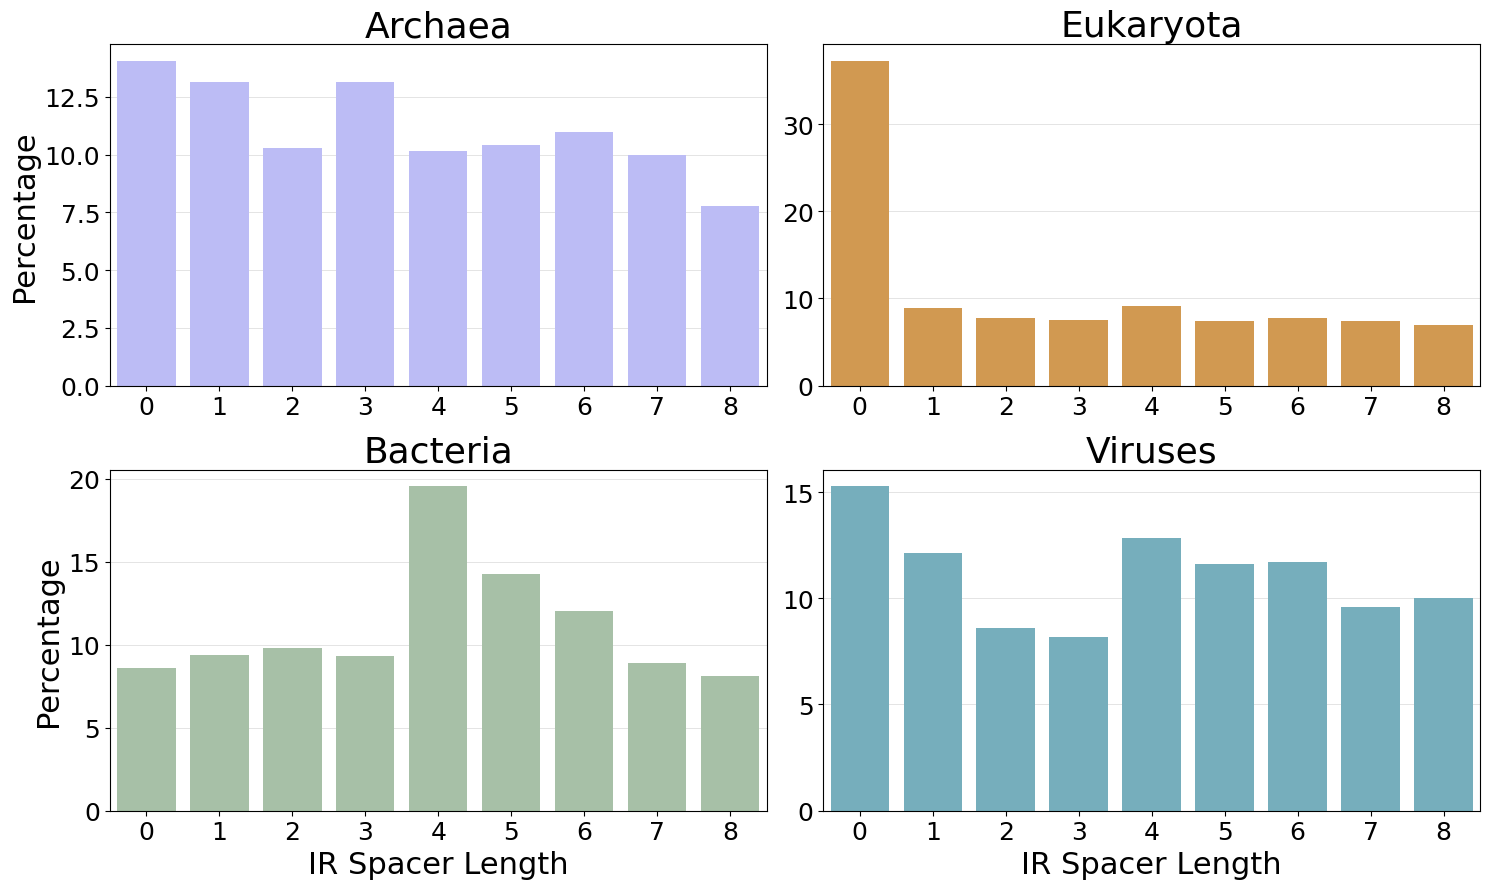

In [83]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))
axes = [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]
for idx, domain in enumerate(domains):
    group_slice = irp_df[irp_df["superkingdom"] == domain]
    total_irp = group_slice.shape[0]
    group_slice = (group_slice.spacerLength.value_counts()*100).div(total_irp)\
                                       .reset_index()
    # print(group_slice.head())
    # group_slice.to_csv(f"{DATABASE}/gap_size_percentage_{domain}.csv", mode="w", index=False)
    cur_ax = axes[idx]
    sns.barplot(data=group_slice, x='spacerLength', y='count', color=domain_colors[domain], ax=cur_ax)
    if idx == 2 or idx == 3:
        cur_ax.set_xlabel("IR Spacer Length")
        cur_ax.xaxis.label.set_size(22)
    else:
        cur_ax.set_xlabel("")
    
    if idx == 0 or idx == 2:
        cur_ax.set_ylabel("Percentage")
        cur_ax.yaxis.label.set_size(22)
    else:
        cur_ax.set_ylabel("")
    
    cur_ax.set_title(domain.capitalize())
    cur_ax.title.set_size(26)
    cur_ax.tick_params(axis="both", which="major", labelsize=18)
    cur_ax.grid(lw=0.4, alpha=0.6, zorder=0)
    cur_ax.xaxis.grid(False)
    cur_ax.set_axisbelow(True)
    
plt.tight_layout()
fig.savefig("/storage/group/izg5139/default/nicole/inverted_repeats/paper_graphs/final_figures/spacer_length_fig_IR.png", bbox_inches='tight')

# GC-TA Content vs. Arm Length Comparison [Barplot]

In [100]:
irp_df.loc[:, "gc"] = irp_df["sequenceOfArm"].str.count("g|c")
irp_df.loc[:, "ta"] = irp_df["sequenceOfArm"].str.count("t|a")

In [102]:
save_location

PosixPath('/storage/group/izg5139/default/nicole/inverted_repeats/paper_graphs/statistics_hairpin')

In [124]:
for domain in tqdm(domains):
    grouped = irp_df[(irp_df['superkingdom'] == domain) & (irp_df["armLength"] < 41)]\
                        .groupby("armLength", as_index=False)\
                        .agg(
                            gc=("gc", "sum"), 
                            ta=("ta", "sum"),
                            avgSpacerLength=("spacerLength", "mean"),
                            totalIR=("sequence", "count")
                        )\
                    .assign(gc=lambda ds: ds['gc'] / ( ds['armLength'] * ds['totalIR'] ))\
                    .assign(ta=lambda ds: ds['ta'] / ( ds['armLength'] * ds['totalIR'] ))
    
    grouped.to_csv(f"{save_location}/arm_gc_ta_comparison_domain_{domain}.csv", mode="w", sep="\t", index=True, header=True)
    

100%|██████████| 4/4 [00:11<00:00,  2.99s/it]


In [ ]:
grouped

# Heatmap Arm Length vs Spacer Length

Archaea


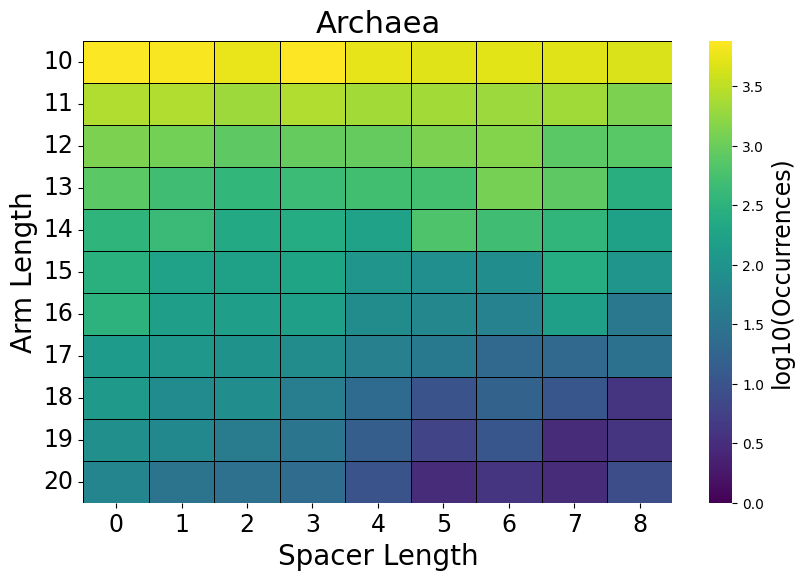

Eukaryota


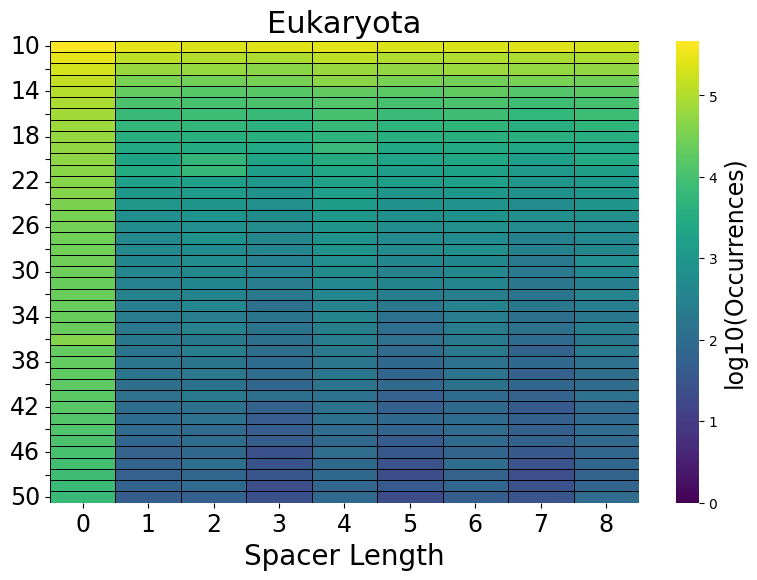

Bacteria


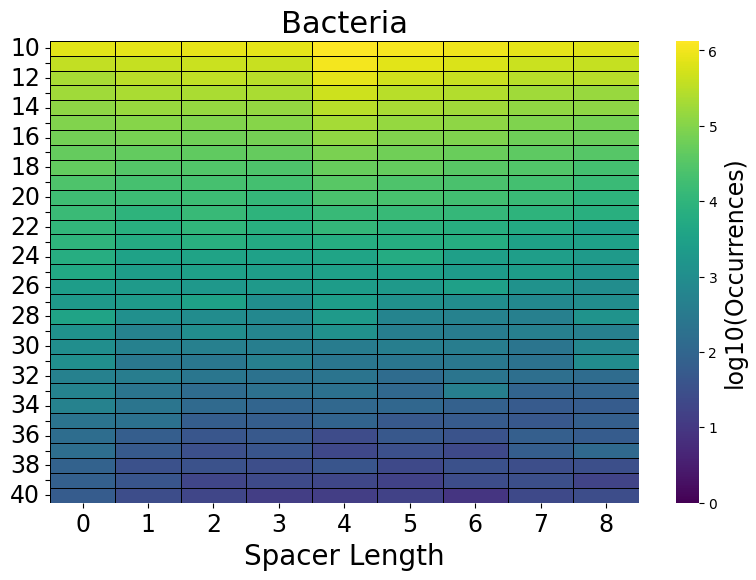

Viruses


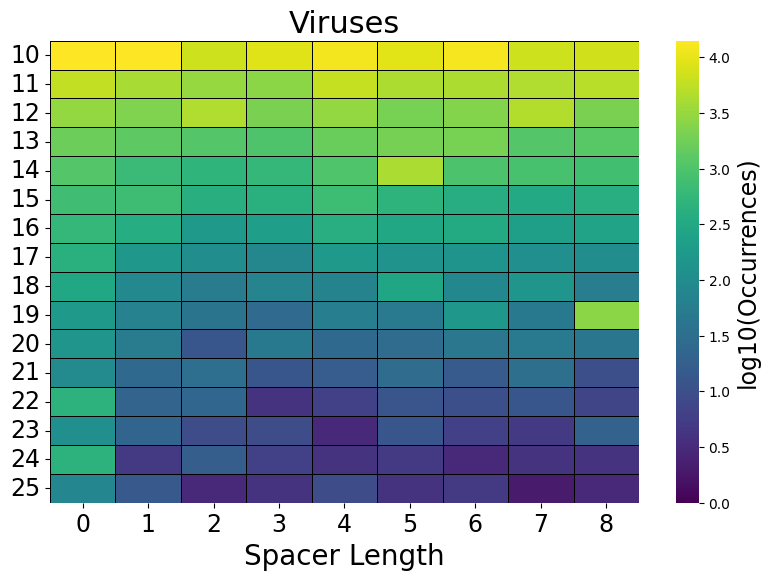

In [13]:
import math
import matplotlib.ticker as plticker

for idx, domain in enumerate(domains):
    print(domain)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9.5, 6))
    if domain == "Archaea":
        irp_df_arm = irp_df[irp_df['armLength'] < 21]
    elif domain == "Eukaryota":
        irp_df_arm = irp_df[irp_df['armLength'] < 51]
    elif domain == "Bacteria":
        irp_df_arm = irp_df[irp_df['armLength'] < 41]
    else:
        irp_df_arm = irp_df[irp_df['armLength'] < 26]
        
    group_slice = irp_df_arm[irp_df_arm["superkingdom"] == domain]
    total_ir = group_slice.shape[0]
    group_slice = group_slice.groupby(["armLength", "spacerLength"], as_index=False)\
                                .agg(totalCounts=("sequenceOfArm", "count"))

    group_slice.loc[:, "totalCounts_log"] = group_slice["totalCounts"].apply(lambda x: math.log(x+1, 10))
                                #.assign(totalPerc=lambda ds: ds['totalCounts'] * 1e2 / total_ir)\
    group_slice = group_slice.pivot(index="armLength", columns="spacerLength", values="totalCounts_log")

    sns.heatmap(data=group_slice, cmap="viridis",
                vmin=0,
                linewidth=0.5,
                linecolor="black",
                ax=ax,
                cbar_kws={'label': 'log10(Occurrences)'})
    
    ax.set_xlabel("Spacer Length")
    if domain == "Archaea":
        ax.set_ylabel("Arm Length")
    else:
        ax.set_ylabel("")
    
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.tick_params(axis="y", rotation=0, labelsize=17)
    ax.tick_params(axis="x", labelsize=17)
    ax.figure.axes[-1].yaxis.label.set_size(17)
    ax.set_title(domain)
    ax.title.set_size(22)

    if domain == "Eukaryota" or domain == "Bacteria":
        ax.set_yticks(ax.get_yticks(), ["" if i%2 != 0 else x for i, x in enumerate(ax.get_yticklabels())])
        
    # loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    # ax.yaxis.set_major_locator(loc)

    
    fig.savefig(f"/storage/group/izg5139/default/nicole/inverted_repeats/paper_graphs/final_figures/heatmap_IR_domain_{domain}.png", bbox_inches='tight')
    plt.show()
    plt.close()

# Heatmap Spacer Length vs. Arm Length Median GC-Content 

In [106]:
irp_df.loc[:, "arm_gc_content"] = irp_df['sequenceOfArm'].str.count("g|c")

In [129]:
temp = irp_df[irp_df['armLength'] < 31]

In [130]:
for domain in tqdm(domains):
    grouped_spacer_arm = temp[temp['superkingdom'] == domain]\
                .groupby(["armLength", "spacerLength"], as_index=False)\
                    .agg(totalGC=("arm_gc_content", "sum"),
                        totalArmLength=("armLength", "sum")
                        )\
                .assign(gcPercentage=lambda ds: (ds['totalGC'] * 1e2) / ds['totalArmLength'] )
    grouped_spacer_arm.to_csv(f"{save_location}/spacer_arm_gc_content_percentage_heatmap_domain_{domain}.csv", sep="\t", mode="w", index=False)
    
grouped_spacer_arm

100%|██████████| 4/4 [00:12<00:00,  3.09s/it]


,armLength,spacerLength,totalGC,totalArmLength,gcPercentage
0,10,0,48766,136930,35.613817
1,10,1,43179,140400,30.754274
2,10,2,26431,68050,38.840558
3,10,3,25312,88720,28.530207
4,10,4,58781,120620,48.732383
...,...,...,...,...,...
174,30,1,2,60,3.333333
175,30,2,6,30,20.000000
176,30,4,162,180,90.000000
177,30,5,21,60,35.000000


# Heatmap Spacer Length vs. Arm Length Median GC-Content 

In [224]:
temp = irp_df[irp_df['armLength'] < 31]

In [226]:
import math

for domain in tqdm(domains):
    grouped_spacer_arm = temp[temp['superkingdom'] == domain]\
                .groupby(["armLength", "spacerLength"], as_index=False)\
                    .agg(totalCounts=("sequenceOfArm", "count"))
    
    grouped_spacer_arm.loc[:, "totalCounts_log"] = grouped_spacer_arm["totalCounts"].apply(lambda x: math.log(x+1, 10))
    # grouped_spacer_arm = grouped_spacer_arm.pivot(index="armLength", columns="spacerLength", values="totalCounts_log").fillna(0.0)
    grouped_spacer_arm.to_csv(f"{save_location}/spacer_arm_total_log_counts_percentage_heatmap_domain_{domain}.csv", sep="\t", mode="w", index=True, header=True)
    
grouped_spacer_arm

100%|██████████| 4/4 [00:12<00:00,  3.06s/it]


,armLength,spacerLength,totalCounts,totalCounts_log
0,10,0,13693,4.136530
1,10,1,14040,4.147398
2,10,2,6805,3.832892
3,10,3,8872,3.948070
4,10,4,12062,4.081455
...,...,...,...,...
174,30,1,2,0.477121
175,30,2,1,0.301030
176,30,4,6,0.845098
177,30,5,2,0.477121


# Boxplot

In [93]:
irp_df.iloc[0]

seqID                                                         AE009951.2
start                                                              17161
end                                                                17183
sequenceOfArm                                                 gtaaaagttt
sequenceOfSpacer                                                      ct
sequence                                          gtaaaagtttctaaacttttac
armLength                                                             10
spacerLength                                                           2
sequenceLength                                                        22
arm_a                                                                  4
arm_g                                                                  2
arm_c                                                                  0
arm_t                                                                  4
composition                                        

In [97]:
irp_df = irp_df[irp_df['spacerLength'] < 9]

In [69]:
irp_df["ir_gc_content"] = irp_df["sequence"].apply(lambda x: (x.count("g") + x.count("c"))/len(x))
irp_df["gc_percent"] = irp_df["gc_percent"].div(100.0)
irp_df.loc[:, "risk_ratio"] = irp_df["ir_gc_content"].div(irp_df["gc_percent"])

In [90]:
def calculate_quantile_df(df, column_name):
    # arm_sizes = df[column_name].sort_values(ascending=True).unique().astype(str)
    
    # outliers
    # outliers = df[~df["odds_ratio"].between(df.lower, df.upper)]
    # p.scatter("arm_size", "ratio", source=outliers, size=6, color="black", alpha=0.3)
    
    # compute quantiles
    qs = df.groupby(column_name)["risk_ratio"].quantile([0.25, 0.5, 0.75])
    qs = qs.unstack().reset_index()
    qs.columns = [column_name, "q1", "q2", "q3"]
    df = pd.merge(df, qs, on=column_name, how="left")

    # compute IQR outlier bounds
    iqr = df.q3 - df.q1
    df["upper"] = df.q3 + 1.5*iqr
    df["lower"] = (df.q1 - 1.5*iqr).apply(lambda x: max(0, x))
    return df[[column_name, "risk_ratio", "q1", "q2", "q3", "lower", "upper"]].drop_duplicates(subset=[column_name])\
                                                                              .sort_values(by=[column_name])\
                                                                              .reset_index(drop=True)
    

In [91]:
save_location

PosixPath('/storage/group/izg5139/default/nicole/inverted_repeats/paper_graphs/statistics_hairpin')

In [141]:
max_arm_size

31

In [94]:
for domain in tqdm(domains, leave=True, position=0):
    print(domain)
    max_arm_size = 21
    grouped_slice = irp_df[(irp_df['superkingdom'] == domain) & (irp_df["armLength"] < max_arm_size)] 
    temp = calculate_quantile_df(grouped_slice, "armLength")
    temp.to_csv(f"{save_location}/arm_length_vs_gc_ratio_content_{domain}.csv", mode="w", index=False, sep="\t")

    temp = calculate_quantile_df(grouped_slice, "spacerLength")
    temp.to_csv(f"{save_location}/spacer_length_vs_gc_ratio_content_{domain}.csv", mode="w", index=False, sep="\t")
    

  0%|          | 0/4 [00:00<?, ?it/s]

Archaea


 25%|██▌       | 1/4 [00:01<00:04,  1.57s/it]

Eukaryota


 50%|█████     | 2/4 [00:10<00:11,  5.86s/it]

Bacteria


 75%|███████▌  | 3/4 [00:39<00:16, 16.41s/it]

Viruses


100%|██████████| 4/4 [00:41<00:00, 10.47s/it]


  0%|          | 0/4 [00:00<?, ?it/s]

Archaea


/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
 25%|██▌       | 1/4 [00:01<00:04,  1.51s/it]

Eukaryota


/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
 50%|█████     | 2/4 [00:03<00:04,  2.08s/it]

Bacteria


/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
 75%|███████▌  | 3/4 [00:10<00:04,  4.10s/it]

Viruses


/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
100%|██████████| 4/4 [00:12<00:00,  3.11s/it]


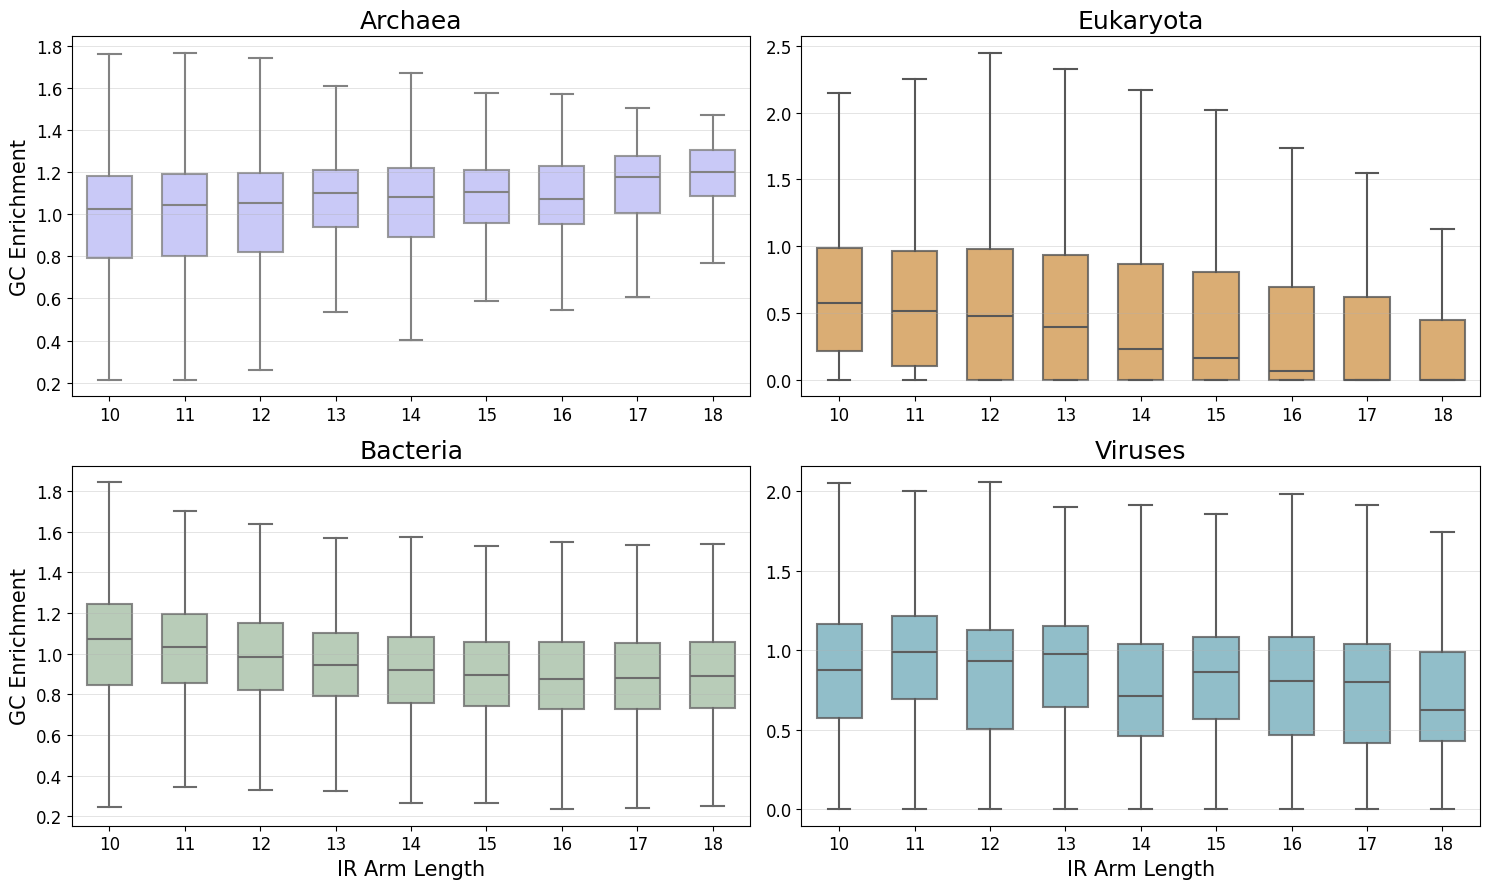

In [70]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))
axes = [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]
max_arm_size = 19

for idx, domain in tqdm(enumerate(domains), total=4):
    print(domain)
    cur_ax = axes[idx]
    grouped_slice = irp_df[(irp_df['superkingdom'] == domain) & (irp_df["armLength"] < max_arm_size)] 
    #.query(f"armLength < {max_arm_size}")
    sns.boxplot(
                data=grouped_slice, 
                x="armLength", 
                y="risk_ratio", 
                ax=cur_ax, 
                color=domain_colors[domain], 
                width=0.6, 
                showfliers=False,  
                zorder=3, 
                # patch_artist=True, 
                boxprops=dict(alpha=0.8)
               )
    
    if idx == 2 or idx == 3:
        cur_ax.set_xlabel("IR Arm Length")
        cur_ax.xaxis.label.set_size(15)
    else:
        cur_ax.set_xlabel("")
    
    if idx == 0 or idx == 2:
        cur_ax.set_ylabel("GC Enrichment")
        cur_ax.yaxis.label.set_size(15)
    else:
        cur_ax.set_ylabel("")
        
    # cur_ax.set_ylim(ymin=0.0, ymax=2.5)
    cur_ax.tick_params(axis="both", which="major", labelsize=12)
    cur_ax.set_title(domain.capitalize())
    cur_ax.title.set_size(18)
    cur_ax.grid(lw=0.4, alpha=0.6, zorder=0)
    cur_ax.xaxis.grid(False)
    # print(temp.shape[0])

    fig.savefig(f"{save_location}/arm_length_vs_gc_ration_content_domain_{domain}.png", bbox_inches='tight')

plt.tight_layout()

In [66]:
save_location = Path("/storage/group/izg5139/default/nicole/inverted_repeats/paper_graphs/statistics_hairpin")
save_location.mkdir(exist_ok=True)

In [67]:
from tqdm import tqdm

for domain in tqdm(domains, leave=True):
    temp = irp_df[(irp_df['superkingdom'] == domain) & (irp_df["armLength"] < 61)]
    temp.loc[:, "arm_gc_content"] = temp["arm_g"] + temp["arm_c"]
    temp.loc[:, "arm_ta_content"] = temp["arm_a"] + temp["arm_t"]
    temp = temp.groupby("armLength", as_index=False)\
                            .agg(totalGC=("arm_gc_content", "sum"),
                                 totalLength=("armLength", "sum"),
                                 totalTA=("arm_ta_content", "sum"),
                                )\
            .assign(GC_prop=lambda ds: ds['totalGC'].div(ds['totalLength']))\
            .assign(TA_prop=lambda ds: ds['totalTA'].div(ds['totalLength']))
    temp.to_csv(f"{save_location}/arm_gc_content_{domain}.csv", mode="w", index=False)

  0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_3460403/4247921354.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.loc[:, "arm_gc_content"] = temp["arm_g"] + temp["arm_c"]
/tmp/ipykernel_3460403/4247921354.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.loc[:, "arm_ta_content"] = temp["arm_a"] + temp["arm_t"]
 25%|██▌       | 1/4 [00:01<00:04,  1.45s/it]/tmp/ipykernel_3460403/4247921354.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

# Spacer Length vs. GC Ratio

  0%|          | 0/4 [00:00<?, ?it/s]

Archaea


/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


9


 25%|██▌       | 1/4 [00:01<00:05,  1.71s/it]

Eukaryota


/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


9


 50%|█████     | 2/4 [00:05<00:05,  2.88s/it]

Bacteria


/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


9


 75%|███████▌  | 3/4 [00:15<00:06,  6.18s/it]

Viruses


/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


9


100%|██████████| 4/4 [00:17<00:00,  4.46s/it]


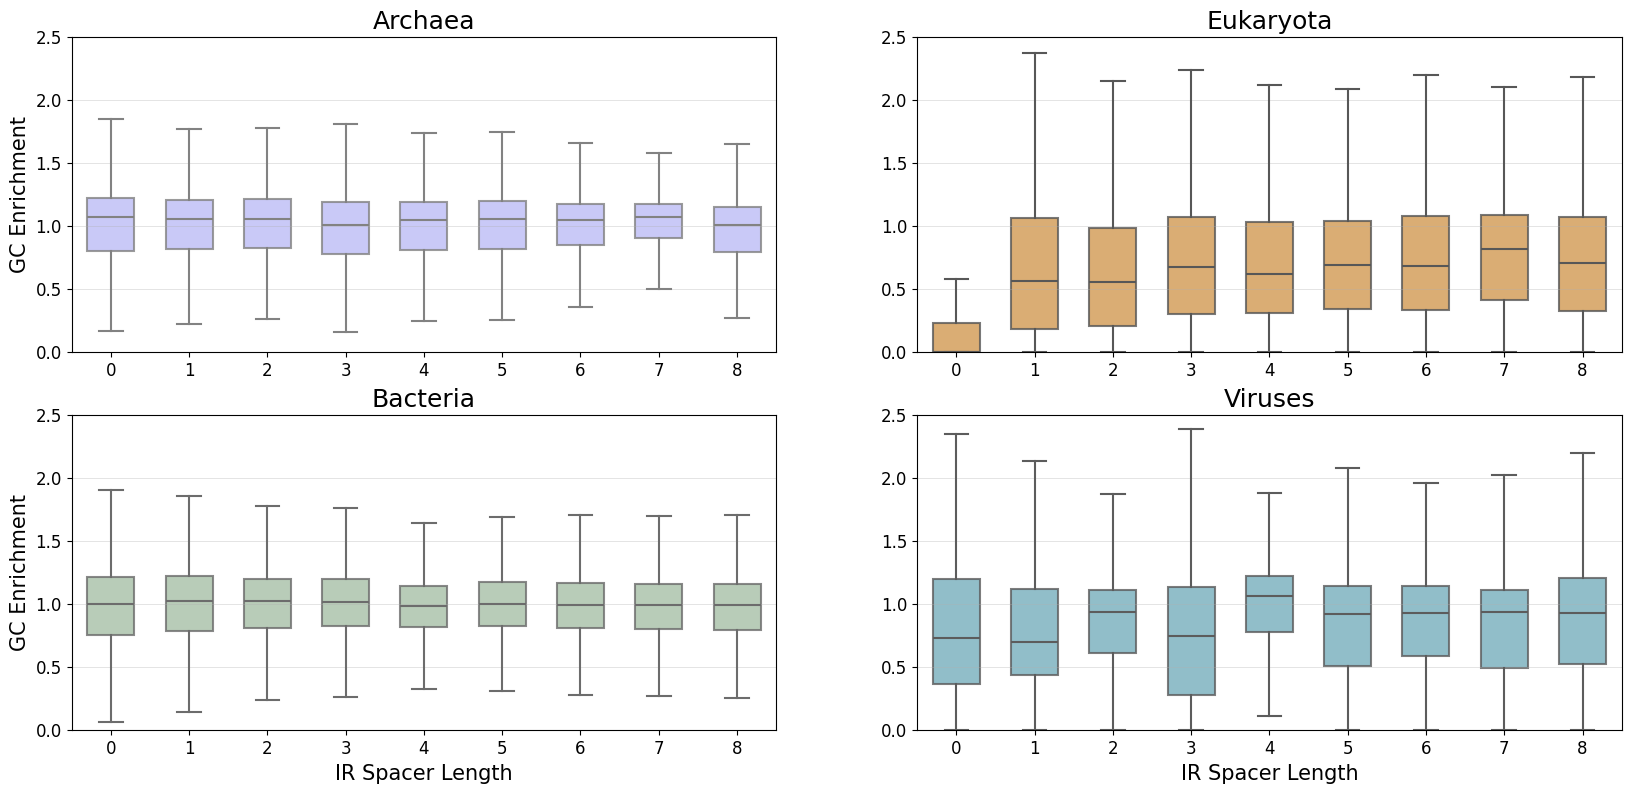

In [97]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 9))
axes = [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]
max_arm_size = 31


for idx, domain in tqdm(enumerate(domains), total=4):
    print(domain)
    cur_ax = axes[idx]
    grouped_slice = irp_df[irp_df['superkingdom'] == domain].query(f"armLength < {max_arm_size}")
    sns.boxplot(data=grouped_slice, 
                    x="spacerLength", 
                    y="risk_ratio", 
                    ax=cur_ax, 
                    color=domain_colors[domain],
                    width=0.6,
                    showfliers=False,  zorder=3, # patch_artist=True, 
                     boxprops=dict(alpha=0.8))
    if idx == 2 or idx == 3:
        cur_ax.set_xlabel("IR Spacer Length")
        cur_ax.xaxis.label.set_size(15)
    else:
        cur_ax.set_xlabel("")
    
    if idx == 0 or idx == 2:
        cur_ax.set_ylabel("GC Enrichment")
        cur_ax.yaxis.label.set_size(15)
    else:
        cur_ax.set_ylabel("")
    
    cur_ax.tick_params(axis="both", which="major", labelsize=12)
    cur_ax.set_title(domain.capitalize())
    cur_ax.title.set_size(18)
    cur_ax.grid(lw=0.4, alpha=0.6, zorder=0)
    cur_ax.xaxis.grid(False)
    cur_ax.set_ylim(ymin=0.0, ymax=2.5)
    print(temp.shape[0])
    # temp.to_csv(f"{save_location}/spacer_length_vs_gc_ratio_content_{domain}.csv.gz", compression="gzip", mode="w", index=False)
    fig.savefig(f"{save_location}/spacer_length_vs_gc_ration_content_domain_{domain}.png", bbox_inches='tight')

# Dinucleotide Plots

In [11]:
from collections import defaultdict, Counter

def count_kmers(seq, kmer_length):
    x = defaultdict(int)
    for i in range(len(seq)-kmer_length+1):
        chunk = seq[i:i+kmer_length]
        
        if chunk in non_canonical_kmers:
            x[non_canonical_kmers[chunk]] += 1
        else:
            x[chunk] += 1
            
    return x

count_kmers("agagagct", 2)

defaultdict(int, {'ct': 4, 'ga': 2, 'gc': 1})

In [10]:
dinucleotides_kmers = [
                   "aa", # tt
                   "at", # at -> palindrome
                   "ag", # ct (swap)
                   "ac", # gt (swap)
                   "ta", # ta -> palindrome
                   "tc", # ga (swap)
                   "tt", # aa (swap)
                   "tg", # ca (swap)
                   "gc", # gc -> palindrome
                   "ga", # tc
                   "gg", # cc
                   "gt", # ac
                   "cg", # cg -> palindrome
                   "cc", # gg (swap)
                   "ct", # ag 
                   "ca", # tg         
    ]

non_canonical_kmers = {
                    "ag": "ct",
                    "ac": "gt",
                    "tc": "ga",
                    "tt": "aa",
                    "cc": "gg",
                    "tg": "ca"
                }

In [8]:
count_kmers("agagaga", 2)

defaultdict(int, {'ag': 3, 'ga': 3})

In [25]:
irp_df = irp_df[irp_df['spacerLength'] < 9].reset_index(drop=True)

In [12]:
count_kmers("agagaga", 1)

defaultdict(int, {'a': 4, 'g': 3})

In [28]:
new_kmer_counts = []

for _, row in tqdm(irp_df.iterrows(), total=irp_df.shape[0], leave=True, position=0):

    new_row = {}
    seq = row['sequenceOfArm']

    mono_counts = count_kmers(seq, 1)
    dinu_counts = count_kmers(seq, 2)
    new_row = dict(row) | mono_counts | dinu_counts
    new_kmer_counts.append(new_row)

new_kmer_counts = pd.DataFrame(new_kmer_counts)
new_kmer_counts

100%|██████████| 29589132/29589132 [36:21<00:00, 13565.90it/s] 


,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,...,ta,aa,ct,at,c,ga,gg,ca,gc,cg
0,AE009951.2,17161,17183,gtaaaagttt,ct,gtaaaagtttctaaacttttac,10,2,22,4,...,1.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AE009951.2,26386,26407,ttaatatatt,t,ttaatatatttaatatattaa,10,1,21,4,...,3.0,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2,AE009951.2,47710,47740,cttctaatact,acatcaca,cttctaatactacatcacaagtattagaag,11,8,30,3,...,2.0,2.0,3.0,1.0,3.0,1.0,NaN,NaN,NaN,NaN
3,AE009951.2,65000,65024,attataaaaa,ccat,attataaaaaccattttttataat,10,4,24,7,...,2.0,5.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
4,AE009951.2,76290,76316,atacccttgat,agaa,atacccttgatagaaatcaagggtat,11,4,26,3,...,1.0,1.0,1.0,2.0,3.0,1.0,2.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29589127,NZ_OY986433.1,2998346,2998371,cactgctgctgg,a,cactgctgctggaccagcagcagtg,12,1,25,1,...,NaN,NaN,3.0,NaN,4.0,NaN,1.0,4.0,2.0,NaN
29589128,NZ_OY986433.1,3028360,3028383,ttgcgggtggc,t,ttgcgggtggctgccacccgcaa,11,1,23,0,...,NaN,1.0,NaN,NaN,2.0,NaN,3.0,2.0,2.0,1.0
29589129,NZ_OY986433.1,3046200,3046226,cggggaggtg,acccac,cggggaggtgacccaccacctccccg,10,6,26,1,...,NaN,NaN,1.0,NaN,1.0,1.0,4.0,1.0,NaN,1.0
29589130,NZ_OY986433.1,3053628,3053648,gtcacccagg,.,gtcacccaggcctgggtgac,10,0,20,2,...,NaN,NaN,1.0,NaN,4.0,1.0,3.0,2.0,NaN,NaN


In [42]:
mono_cols = ['a', 'g', 'c', 't']
dinu_cols = ['gt', 'ta', 'aa', 'ct', 'at', 'ga', 'gg', 'ca', 'gc', 'cg']
cols = ['g', 't', 'a', 'c', 'gt', 'ta', 'aa', 'ct', 'at', 'ga', 'gg', 'ca', 'gc', 'cg']

In [ ]:
dinucleotide_colors = {
                       "cc": "crimson",
                       "gg": "green",
                       "gt": "darkgreen",
                       "tg": "gold",
                       "ct": "maroon",
                       "tc": "magenta",
                       "gc": "orange",
                       "cg": "purple",
                       "tt": "lightgreen",
                       "ta": "navy",
                       "at": "pink",
                       "aa": "lightblue",
                       "ag": "yellow",
                       "ga": "blue",
                       "ac": "gray",
                       "ca": "black"
                       }

In [32]:
new_kmer_counts[cols] = new_kmer_counts[cols].fillna(0.0).astype(int)
new_kmer_counts

,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,...,ta,aa,ct,at,c,ga,gg,ca,gc,cg
0,AE009951.2,17161,17183,gtaaaagttt,ct,gtaaaagtttctaaacttttac,10,2,22,4,...,1,5,1,0,0,0,0,0,0,0
1,AE009951.2,26386,26407,ttaatatatt,t,ttaatatatttaatatattaa,10,1,21,4,...,3,3,0,3,0,0,0,0,0,0
2,AE009951.2,47710,47740,cttctaatact,acatcaca,cttctaatactacatcacaagtattagaag,11,8,30,3,...,2,2,3,1,3,1,0,0,0,0
3,AE009951.2,65000,65024,attataaaaa,ccat,attataaaaaccattttttataat,10,4,24,7,...,2,5,0,2,0,0,0,0,0,0
4,AE009951.2,76290,76316,atacccttgat,agaa,atacccttgatagaaatcaagggtat,11,4,26,3,...,1,1,1,2,3,1,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29589127,NZ_OY986433.1,2998346,2998371,cactgctgctgg,a,cactgctgctggaccagcagcagtg,12,1,25,1,...,0,0,3,0,4,0,1,4,2,0
29589128,NZ_OY986433.1,3028360,3028383,ttgcgggtggc,t,ttgcgggtggctgccacccgcaa,11,1,23,0,...,0,1,0,0,2,0,3,2,2,1
29589129,NZ_OY986433.1,3046200,3046226,cggggaggtg,acccac,cggggaggtgacccaccacctccccg,10,6,26,1,...,0,0,1,0,1,1,4,1,0,1
29589130,NZ_OY986433.1,3053628,3053648,gtcacccagg,.,gtcacccaggcctgggtgac,10,0,20,2,...,0,0,1,0,4,1,3,2,0,0


In [44]:
dinu_cols

['gt', 'ta', 'aa', 'ct', 'at', 'ga', 'gg', 'ca', 'gc', 'cg']

In [ ]:
sns.barplot(data=grouped_domain.reset_index())

In [64]:
grouped_domain

,g,t,a,c,gt,ta,aa,ct,at,ga,gg,ca,gc,cg,armLength,totalIRs,spacerLength,mono_sum,dinu_sum
armLength,,,,,,,,,,,,,,,,,,,
10,19.471696,27.423637,33.310069,19.794598,8.082470,10.367540,20.582071,9.066782,11.581303,9.324332,12.180823,9.141016,5.239108,4.434555,814986,90554,3.588080,905540,814986
11,22.452112,24.461139,31.264325,21.822424,8.268985,7.964928,20.282983,10.753368,8.446100,9.718773,14.624570,8.284288,6.191516,5.464489,398610,39861,4.054690,438471,398610
12,18.838758,29.081401,32.917235,19.162606,9.565033,12.815152,19.436580,9.932496,11.949469,9.067522,11.144027,6.497050,4.658670,4.934002,282205,25655,3.965894,307860,282205
13,19.869679,24.841330,31.907422,23.381569,8.436796,8.804809,20.075043,11.573419,8.533056,9.426240,14.952983,8.211535,5.585678,4.400440,152712,12726,4.007072,165438,152712
14,13.489722,24.380064,42.997172,19.133041,7.605927,11.317385,29.371029,11.856900,9.273521,8.717900,9.158590,5.204094,4.143363,3.351293,136604,10508,4.360678,147112,136604
15,17.113777,28.106143,34.245002,20.535078,8.512229,10.322480,23.977255,9.079296,10.548372,8.128992,12.804175,8.038635,4.667394,3.921172,64190,4585,3.413086,68775,64190
16,16.902807,29.594809,35.131974,18.370410,7.676554,11.873823,24.512712,8.575800,12.172787,7.770716,11.412429,7.271657,4.555085,4.178437,42480,2832,3.501059,45312,42480
17,14.642959,31.774449,36.962611,16.619981,7.285197,13.729296,26.501035,7.763975,13.793996,7.073844,9.554003,6.526052,3.959627,3.812974,23184,1449,3.068323,24633,23184
18,16.850242,33.835749,32.661836,16.652174,8.613811,13.442455,25.785166,8.296675,11.923274,5.959079,9.028133,7.222506,5.248082,4.480818,19550,1150,3.561739,20700,19550


In [63]:
for domain in tqdm(domains, leave=True, position=0):
    grouped_domain = new_kmer_counts[(new_kmer_counts['superkingdom'] == domain) & (new_kmer_counts['armLength'] < 41)]\
                                .groupby(["armLength"])\
                                .agg({canonical_kmer: "sum" for canonical_kmer in cols} | {"armLength": lambda ds: ds.sum() - ds.count(), 
                                                                                           "sequenceLength": "count",
                                                                                           "spacerLength": "mean"})\
                                .rename(columns={"sequenceLength": "totalIRs"})

    grouped_domain.loc[:, "mono_sum"] = grouped_domain[mono_cols].sum(axis=1)
    grouped_domain.loc[:, "dinu_sum"] = grouped_domain[dinu_cols].sum(axis=1)
    
    grouped_domain[dinu_cols] = 1e2 * grouped_domain[dinu_cols].apply(lambda row: row/row.sum(), axis=1)
    grouped_domain[mono_cols] = 1e2 * grouped_domain[mono_cols].apply(lambda row: row/row.sum(), axis=1)

    save_location = Path("/storage/group/izg5139/default/nicole/inverted_repeats/dinucleotides")
    save_location.mkdir(exist_ok=True)
    
    grouped_domain.to_csv(f"{save_location}/mono_dinucleotide_ratios_domain_{domain}.csv", mode="w", sep="\t", index=True, header=True)

100%|██████████| 4/4 [00:14<00:00,  3.53s/it]


In [ ]:
/storage/group/izg5139/default/nicole/inverted_repeats/dinucleotides/

In [ ]:
groupe

In [114]:
dinnucleotides = {
    "aa",
    "at",
    "gc",
}

canonical_dinucleotides = {

}

In [113]:
irp_df

,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,...,composition,#assembly_accession,gc_percent,organism_name,phylum,kingdom,superkingdom,genome_size,ir_gc_content,risk_ratio
0,AE009951.2,17161,17183,gtaaaagttt,ct,gtaaaagtttctaaacttttac,10,2,22,4,...,4A/0C/2G/4T,GCA_000007325.1,0.27,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500,0.227273,0.841751
1,AE009951.2,26386,26407,ttaatatatt,t,ttaatatatttaatatattaa,10,1,21,4,...,4A/0C/0G/6T,GCA_000007325.1,0.27,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500,0.000000,0.000000
2,AE009951.2,47710,47740,cttctaatact,acatcaca,cttctaatactacatcacaagtattagaag,11,8,30,3,...,3A/3C/0G/5T,GCA_000007325.1,0.27,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500,0.300000,1.111111
3,AE009951.2,65000,65024,attataaaaa,ccat,attataaaaaccattttttataat,10,4,24,7,...,7A/0C/0G/3T,GCA_000007325.1,0.27,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500,0.083333,0.308642
4,AE009951.2,76290,76316,atacccttgat,agaa,atacccttgatagaaatcaagggtat,11,4,26,3,...,3A/3C/1G/4T,GCA_000007325.1,0.27,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500,0.346154,1.282051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29777215,NZ_OY986433.1,2998346,2998371,cactgctgctgg,a,cactgctgctggaccagcagcagtg,12,1,25,1,...,1A/4C/4G/3T,GCF_963920505.1,0.66,Synechococcus sp. CBW1107,Cyanobacteriota,Eubacteria,Bacteria,3085273,0.640000,0.969697
29777216,NZ_OY986433.1,3028360,3028383,ttgcgggtggc,t,ttgcgggtggctgccacccgcaa,11,1,23,0,...,0A/2C/6G/3T,GCF_963920505.1,0.66,Synechococcus sp. CBW1107,Cyanobacteriota,Eubacteria,Bacteria,3085273,0.695652,1.054018
29777217,NZ_OY986433.1,3046200,3046226,cggggaggtg,acccac,cggggaggtgacccaccacctccccg,10,6,26,1,...,1A/1C/7G/1T,GCF_963920505.1,0.66,Synechococcus sp. CBW1107,Cyanobacteriota,Eubacteria,Bacteria,3085273,0.769231,1.165501
29777218,NZ_OY986433.1,3053628,3053648,gtcacccagg,.,gtcacccaggcctgggtgac,10,0,20,2,...,2A/4C/3G/1T,GCF_963920505.1,0.66,Synechococcus sp. CBW1107,Cyanobacteriota,Eubacteria,Bacteria,3085273,0.700000,1.060606


# GC Content Comparison

In [143]:
irp_df.iloc[0]

seqID                                                         AE009951.2
start                                                              17161
end                                                                17183
sequenceOfArm                                                 gtaaaagttt
sequenceOfSpacer                                                      ct
sequence                                          gtaaaagtttctaaacttttac
armLength                                                             10
spacerLength                                                           2
sequenceLength                                                        22
arm_a                                                                  4
arm_g                                                                  2
arm_c                                                                  0
arm_t                                                                  4
composition                                        

In [147]:
irp_df.loc[:, "ta_percent"] = 1 - irp_df["gc_percent"]

In [153]:
irp_df.loc[:, "arm_gc_content"] = irp_df["sequenceOfArm"].str.count("g|c") #.div(irp_df['armLength'])
irp_df.loc[:, "arm_ta_content"] = irp_df["sequenceOfArm"].str.count("t|a") #.div(irp_df['armLength'])

In [168]:
temp = irp_df[irp_df['superkingdom'] == 'Archaea']\
                .groupby("#assembly_accession")\
                .agg({
                      "arm_gc_content": "sum",
                      "armLength": "sum",
                      "arm_ta_content": "sum",
                      "gc_percent": "first",
                      "ta_percent": "first",
                     })\
                .assign(gc_prop=lambda ds: 1e2 * ds['arm_gc_content'].div(ds['armLength']))\
                .assign(ta_prop=lambda ds: 1e2 * ds['arm_ta_content'].div(ds['armLength']))
temp

,arm_gc_content,armLength,arm_ta_content,gc_percent,ta_percent,gc_prop,ta_prop
#assembly_accession,,,,,,,
GCA_000008085.1,53.0,175,122.0,0.315,0.685,30.285714,69.714286
GCA_000016605.1,99.0,251,152.0,0.460,0.540,39.442231,60.557769
GCA_000145985.1,231.0,828,597.0,0.355,0.645,27.898551,72.101449
GCA_000224475.1,3601.0,5372,1771.0,0.625,0.375,67.032762,32.967238
GCA_000230955.3,1652.0,2351,699.0,0.665,0.335,70.267971,29.732029
...,...,...,...,...,...,...,...
GCF_963668475.1,371.0,977,606.0,0.470,0.530,37.973388,62.026612
GCF_963674485.1,639.0,1831,1192.0,0.415,0.585,34.898962,65.101038
GCF_963677065.1,397.0,850,453.0,0.545,0.455,46.705882,53.294118


In [185]:
ir_values = pd.melt(temp, value_vars=['gc_prop', 'ta_prop'])
ir_values

,variable,value
0,gc_prop,30.285714
1,gc_prop,39.442231
2,gc_prop,27.898551
3,gc_prop,67.032762
4,gc_prop,70.267971
...,...,...
1369,ta_prop,62.026612
1370,ta_prop,65.101038
1371,ta_prop,53.294118
1372,ta_prop,64.928910


In [186]:
ir_values = pd.melt(temp, value_vars=['gc_prop', 'ta_prop'], var_name="typ", value_name="content")
ir_values.loc[:, "origin"] = "ir"
genome_values = pd.melt(temp, value_vars=['gc_percent', 'ta_percent'], var_name="typ", value_name="content")
genome_values.loc[:, "origin"] = "genome"

all_values = pd.concat([ir_values, genome_values], axis=0)
all_values

,typ,content,origin
0,gc_prop,30.285714,ir
1,gc_prop,39.442231,ir
2,gc_prop,27.898551,ir
3,gc_prop,67.032762,ir
4,gc_prop,70.267971,ir
...,...,...,...
1369,ta_percent,0.530000,genome
1370,ta_percent,0.585000,genome
1371,ta_percent,0.455000,genome
1372,ta_percent,0.600000,genome


In [191]:
all_values.isna().sum()

typ        0
content    0
origin     0
dtype: int64

In [169]:
concatenated_df = pd.concat([
    pd.melt(temp, value_vars=['gc_prop', 'ta_prop'], var_name="ir", value_name="ir_content"),
    pd.melt(temp, value_vars=['gc_percent', 'ta_percent'], var_name="genome", value_name="genome_content"),
],
          axis=1
         )
concatenated_df.loc[:, "ir"] = concatenated_df["ir"].str.replace("arm_gc_content", "GC Content").str.replace("arm_ta_content", "TA Content")
# concatenated_df.loc[:, "genome"] = concatenated_df["genome"].str.replace("gc_percent", "TA Content").str.replace("arm_ta_content", "TA Content")
concatenated_df

,ir,ir_content,genome,genome_content
0,gc_prop,30.285714,gc_percent,0.315
1,gc_prop,39.442231,gc_percent,0.460
2,gc_prop,27.898551,gc_percent,0.355
3,gc_prop,67.032762,gc_percent,0.625
4,gc_prop,70.267971,gc_percent,0.665
...,...,...,...,...
1369,ta_prop,62.026612,ta_percent,0.530
1370,ta_prop,65.101038,ta_percent,0.585
1371,ta_prop,53.294118,ta_percent,0.455
1372,ta_prop,64.928910,ta_percent,0.600


In [193]:
all_values.isn

,typ,content,origin
0,gc_prop,30.285714,ir
1,gc_prop,39.442231,ir
2,gc_prop,27.898551,ir
3,gc_prop,67.032762,ir
4,gc_prop,70.267971,ir
...,...,...,...
1369,ta_percent,0.530000,genome
1370,ta_percent,0.585000,genome
1371,ta_percent,0.455000,genome
1372,ta_percent,0.600000,genome


In [222]:
save_location

PosixPath('/storage/group/izg5139/default/nicole/inverted_repeats/paper_graphs/statistics_hairpin')

In [228]:
save_location

PosixPath('/storage/group/izg5139/default/nicole/inverted_repeats/paper_graphs/statistics_hairpin')

Archaea
Rectangle(xy=(0, 0), width=0, height=0, angle=0) pink
PathPatch6((-0.2475, 28.053) ...) pink
Rectangle(xy=(0, 0), width=0, height=0, angle=0) gray
PathPatch6((0.0025, 39.5) ...) gray
PathPatch6((0.7525, 30.3444) ...) lightblue
PathPatch6((1.0025, 37) ...) gray


/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

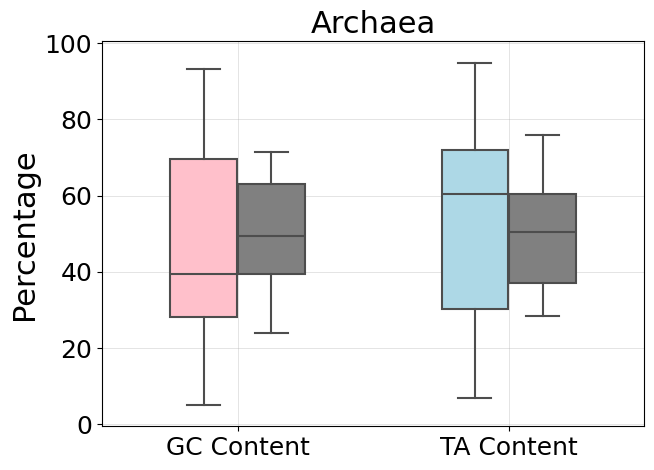

Eukaryota
Rectangle(xy=(0, 0), width=0, height=0, angle=0) pink
PathPatch6((-0.2475, 18.7508) ...) pink
Rectangle(xy=(0, 0), width=0, height=0, angle=0) gray
PathPatch6((0.0025, 40) ...) gray
PathPatch6((0.7525, 63.6914) ...) lightblue
PathPatch6((1.0025, 49.875) ...) gray


/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

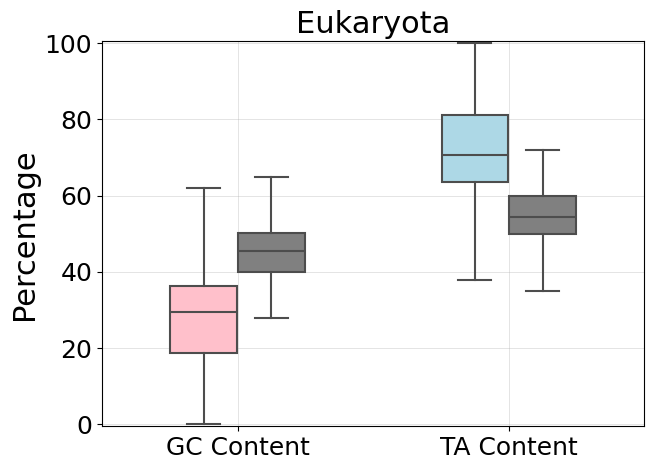

Bacteria
Rectangle(xy=(0, 0), width=0, height=0, angle=0) pink
PathPatch6((-0.2475, 33.5152) ...) pink
Rectangle(xy=(0, 0), width=0, height=0, angle=0) gray
PathPatch6((0.0025, 39) ...) gray
PathPatch6((0.7525, 39.9263) ...) lightblue
PathPatch6((1.0025, 41.5) ...) gray


/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

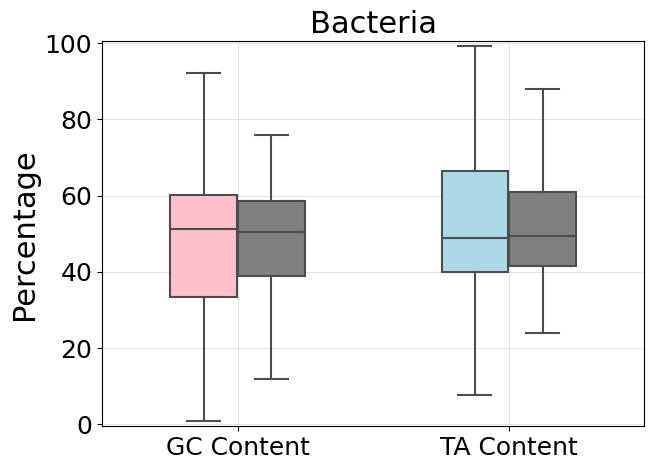

Viruses
Rectangle(xy=(0, 0), width=0, height=0, angle=0) pink
PathPatch6((-0.2475, 25.1932) ...) pink
Rectangle(xy=(0, 0), width=0, height=0, angle=0) gray
PathPatch6((0.0025, 35.5) ...) gray
PathPatch6((0.7525, 40) ...) lightblue
PathPatch6((1.0025, 46.5) ...) gray


/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

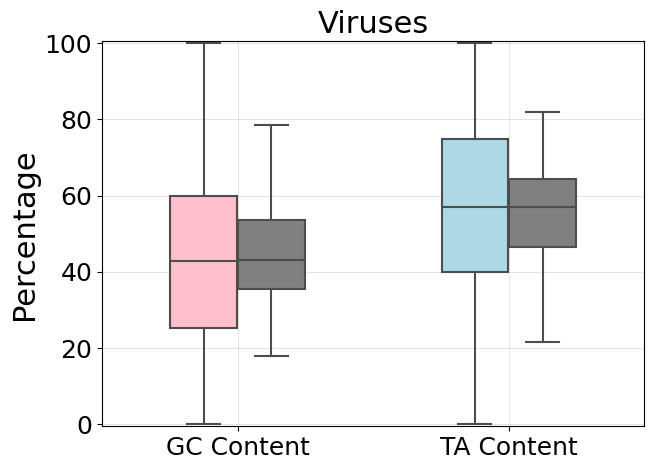

In [230]:
for domain in domains:
    print(domain)
    temp = irp_df[irp_df['superkingdom'] == domain]\
                .groupby("#assembly_accession")\
                .agg({
                      "arm_gc_content": "sum",
                      "armLength": "sum",
                      "arm_ta_content": "sum",
                      "gc_percent": "first",
                      "ta_percent": "first",
                     })\
                .assign(gc_prop=lambda ds: 1e2 * ds['arm_gc_content'].div(ds['armLength']))\
                .assign(ta_prop=lambda ds: 1e2 * ds['arm_ta_content'].div(ds['armLength']))
    
    temp.loc[:, "gc_percent"] = 1e2 * temp["gc_percent"]
    temp.loc[:, "ta_percent"] = 1e2 * temp["ta_percent"]
    
    # concatenated_df = pd.concat([
    #    pd.melt(temp, value_vars=['gc_prop', 'ta_prop'], var_name="ir", value_name="ir_content"),
    #    pd.melt(temp, value_vars=['gc_percent', 'ta_percent'], var_name="genome", value_name="genome_content"),
    #],
    #          axis=1
    #         )
    # concatenated_df.loc[:, "ir"] = concatenated_df["ir"].str.replace("gc_prop", "GC Content").str.replace("ta_prop", "TA Content")
    ir_values = pd.melt(temp, value_vars=['gc_prop', 'ta_prop'], var_name="typ", value_name="content")
    ir_values.loc[:, "origin"] = "ir"
    genome_values = pd.melt(temp, value_vars=['gc_percent', 'ta_percent'], var_name="typ", value_name="content")
    genome_values.loc[:, "origin"] = "genome"

    #create your own color array 
    my_colors = ["pink", "gray", "lightblue", "gray"] 
  
    # add color array to set_palette 
    # function of seaborn 
    sns.set_palette(my_colors) 
        
    all_values = pd.concat([ir_values, genome_values], axis=0)
    all_values.loc[:, "typ"] = all_values["typ"].apply(lambda x: x.replace("gc_prop", "GC Content")\
                                                                           .replace("ta_prop", "TA Content")\
                                                                           .replace("gc_percent", "GC Content")\
                                                                            .replace("ta_percent", "TA Content")
                                                              )

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
    boxplot = sns.boxplot(
        data=all_values,
        width=0.5,
        x="typ",
        y="content",
        palette={
                 "ir": "pink",
                 "genome": "gray",
                },
        hue="origin",
        showfliers=False,
        ax=ax,
        zorder=3
        )
        # Set custom colors
    colors = ['pink', 'pink', 'gray', 'gray', 'lightblue', 'gray']  # Add more colors as needed
    
    # Find the number of boxes
    n_boxes = len(boxplot.patches)
    
    # Loop over each box
    for i, patch in enumerate(boxplot.patches):
        col = colors[i % len(colors)]
        print(patch, col)
        patch.set_facecolor(col)
        # patch.set_edgecolor('black')
        

    ax.grid(lw=0.4, alpha=0.6, zorder=0)
    ax.set_xlabel("")
    ax.set_ylabel("Percentage")
    ax.set_title(domain.capitalize())
    ax.title.set_size(22)
    
    ax.xaxis.label.set_size(22)
    ax.yaxis.label.set_size(22)
    ax.tick_params(axis="both", labelsize=18)
    ax.set_axisbelow(True)
    ax.set_ylim(-0.5, 100.5)
    ax.legend(handles=[], frameon=False)

    plt.show()
    plt.close()
    fig.savefig(f"{save_location}/boxplot_gc_ta_content_domain_{domain}.png", bbox_inches='tight')